In [5]:
# import packages
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Causal Question:
What is the causal effect of being contacted via cellular phone (vs telephone) on the probability of subscription (y_bin)?

so treatment is defined as:

Treatment (T) = contact (cellular vs telephone)

Outcome (Y) = y_bin

Confounders (X) = pre-treatment variables only

In [6]:
# import processed data
data_path = Path("../data/processed/bank_clean.csv")
df = pd.read_csv(data_path)

df.shape

(41188, 22)

In [7]:
# encode treatment variable
df["treatment"] = (df["contact"] == "cellular").astype(int)
df[["contact", "treatment"]].head()

,contact,treatment
0,telephone,0
1,telephone,0
2,telephone,0
3,telephone,0
4,telephone,0


In [8]:
# encode outcome variable
df["outcome"] = df["y_bin"]
df[["outcome"]].value_counts()

outcome
0          36548
1           4640
Name: count, dtype: int64

In [9]:
# identify confounder variables
confounders = [
    "age",
    "job",
    "marital",
    "education",
    "default",
    "housing",
    "loan",
    "campaign",
    "pdays",
    "previous",
    "poutcome",
    "emp.var.rate",
    "cons.price.idx",
    "cons.conf.idx",
    "euribor3m",
    "nr.employed",
    "month",
    "day_of_week"
]

In [10]:
# check treatment balance
df["treatment"].value_counts(normalize=True)

treatment
1    0.634748
0    0.365252
Name: proportion, dtype: float64

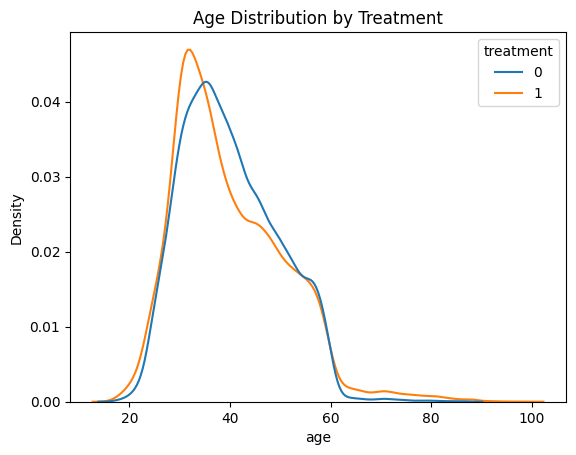

In [11]:
# visualize treatment by age
sns.kdeplot(data=df, x="age", hue="treatment", common_norm=False)
plt.title("Age Distribution by Treatment")
plt.show()

This tells me that:

Treatment assignment is not random
Age distribution differs slightly
We must adjust for age in the propensity model

But importantly:
There is sufficient overlap → causal estimation is possible.

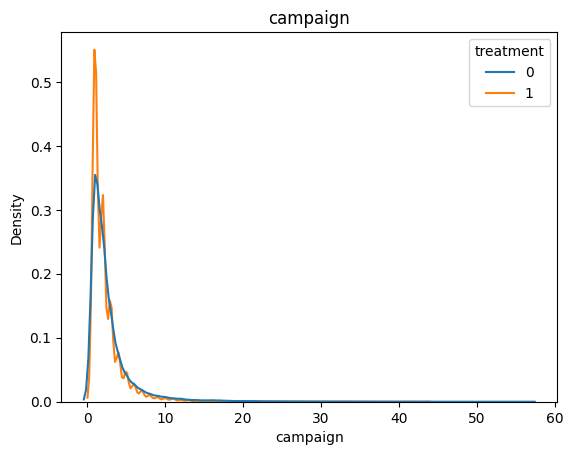

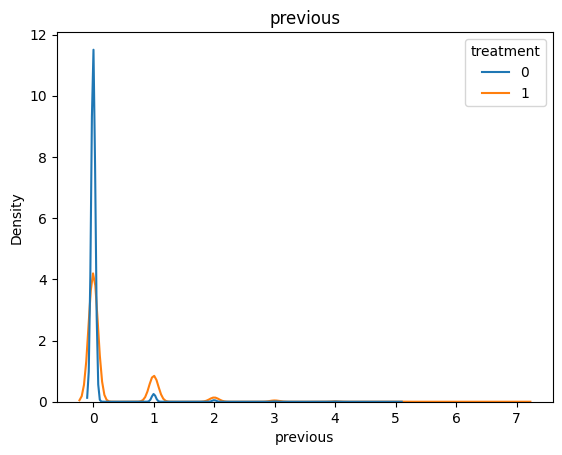

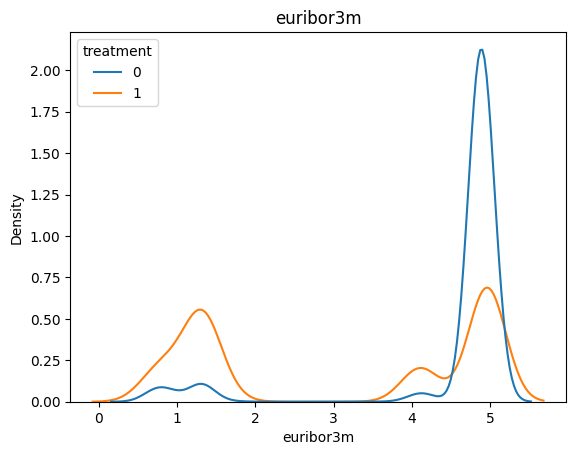

In [12]:
# 1 more overlap check
for col in ["campaign", "previous", "euribor3m"]:
    sns.kdeplot(data=df, x=col, hue="treatment", common_norm=False)
    plt.title(col)
    plt.show()

Treatment assignment is clearly non-random.
Especially macroeconomic variables like euribor3m show substantial imbalance between groups, indicating selection bias.
However, overlap exists across covariates, so the positivity assumption appears satisfied.
Therefore, IPW is appropriate.

In [13]:
# treatment assignment rate
df["treatment"].mean()

np.float64(0.6347479848499563)

In [14]:
# define SMD function for weighting
def smd_numeric(df, treatment_col, covariate):
    treated = df[df[treatment_col] == 1][covariate]
    control = df[df[treatment_col] == 0][covariate]
    
    mean_diff = treated.mean() - control.mean()
    pooled_std = np.sqrt((treated.var() + control.var()) / 2)
    
    return mean_diff / pooled_std

In [15]:
# compute SMD weighting
covariates = [
    "age", "campaign", "previous",
    "emp.var.rate", "cons.price.idx",
    "cons.conf.idx", "euribor3m", "nr.employed"
]

smd_results = []

for col in covariates:
    smd_val = smd_numeric(df, "treatment", col)
    smd_results.append({"variable": col, "smd": smd_val})

smd_df = pd.DataFrame(smd_results)
smd_df["abs_smd"] = smd_df["smd"].abs()

smd_df.sort_values("abs_smd", ascending=False)

,variable,smd,abs_smd
4,cons.price.idx,-1.553742,1.553742
6,euribor3m,-0.961686,0.961686
3,emp.var.rate,-0.945923,0.945923
7,nr.employed,-0.614750,0.614750
5,cons.conf.idx,-0.567148,0.567148
2,previous,0.494951,0.494951
1,campaign,-0.154915,0.154915
0,age,-0.014871,0.014871


Rules of thumb to interpre above outputs:
	
< 0.1	Well balanced
0.1–0.2	Mild imbalance
0.2–0.5	Moderate imbalance
> 0.5	Serious imbalance

euribor3m shows >0.5, that confirms what we saw visually above.

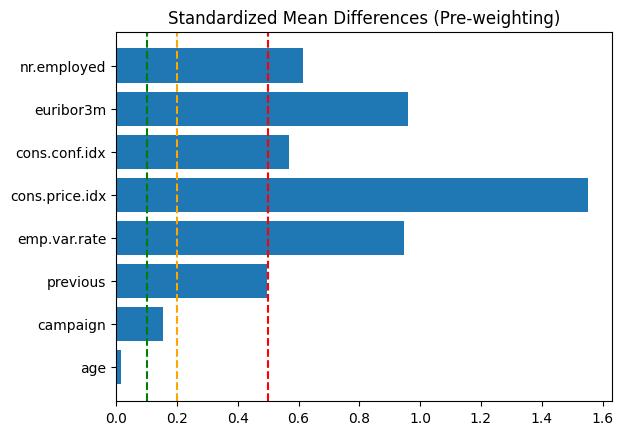

In [16]:
# weighting visual
plt.barh(smd_df["variable"], smd_df["abs_smd"])
plt.axvline(0.1, color="green", linestyle="--")
plt.axvline(0.2, color="orange", linestyle="--")
plt.axvline(0.5, color="red", linestyle="--")
plt.title("Standardized Mean Differences (Pre-weighting)")
plt.show()

for the visual above:
green line is the cutoff for well balanaced.
orange line is the cutoff for mild imabalance.
red line is the cutoff for moderate imbalance.
and, anything to the right of the red line is all serious imbalance.